
#  Task 2: End-to-End ML Pipeline with Scikit-learn Pipeline API
# **Objective**: Build a production-ready ML pipeline for predicting customer churn using the Telco Churn Dataset.
# **Dataset**: Telco Customer Churn Dataset (Kaggle/UCI).
# **Steps**: Preprocess data, train models (Logistic Regression, Random Forest), tune hyperparameters, evaluate, and export pipeline.




# 1. Import Libraries


In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# 2. Load and Preprocess Dataset



In [3]:
# Load dataset
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Basic cleaning
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")  # Convert to numeric, handle errors
data["TotalCharges"].fillna(data["TotalCharges"].median(), inplace=True)  # Impute missing values
data.drop("customerID", axis=1, inplace=True)  # Drop irrelevant column

# Define features and target
X = data.drop("Churn", axis=1)
y = data["Churn"].map({"Yes": 1, "No": 0})  # Convert to binary (1=Churn, 0=No Churn)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)  # 80% train, 10% val, 10% test

# Define numerical and categorical columns
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_cols = [col for col in X.columns if col not in numerical_cols]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ]
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_12312\1698658039.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TotalCharges"].fillna(data["TotalCharges"].median(), inplace=True)  # Impute missing values



# 3. Model Development and Training



In [4]:
# Define pipelines
logreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42))
])

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Hyperparameter grids
logreg_param_grid = {
    "classifier__C": [0.1, 1.0, 10.0],
    "classifier__solver": ["lbfgs", "liblinear"]
}

rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5]
}

# Perform GridSearchCV
logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring="f1", n_jobs=-1)
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring="f1", n_jobs=-1)

# Fit models
logreg_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)

# Best models
best_logreg = logreg_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Print best parameters
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)
print("Best Random Forest Parameters:", rf_grid.best_params_)

Best Logistic Regression Parameters: {'classifier__C': 10.0, 'classifier__solver': 'lbfgs'}
Best Random Forest Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}



# 4. Evaluation



Logistic Regression Metrics: {'Accuracy': 0.8019872249822569, 'Precision': 0.6517571884984026, 'Recall': 0.5454545454545454, 'F1-Score': 0.5938864628820961}


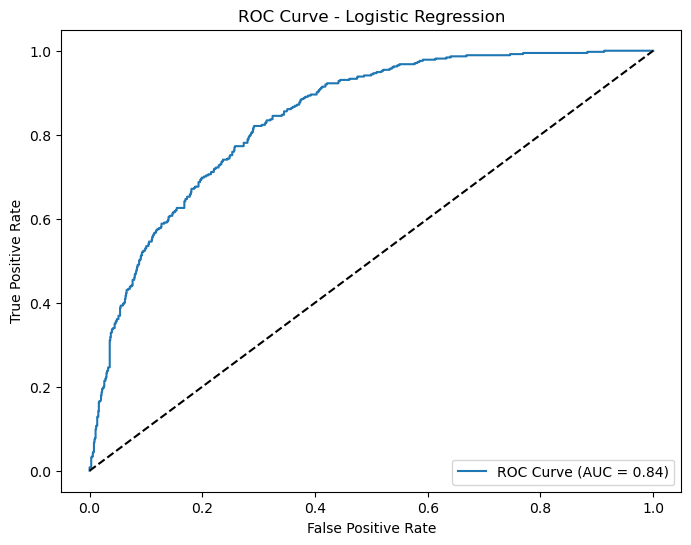

Random Forest Metrics: {'Accuracy': 0.8048261178140526, 'Precision': 0.6689419795221843, 'Recall': 0.5240641711229946, 'F1-Score': 0.5877061469265368}


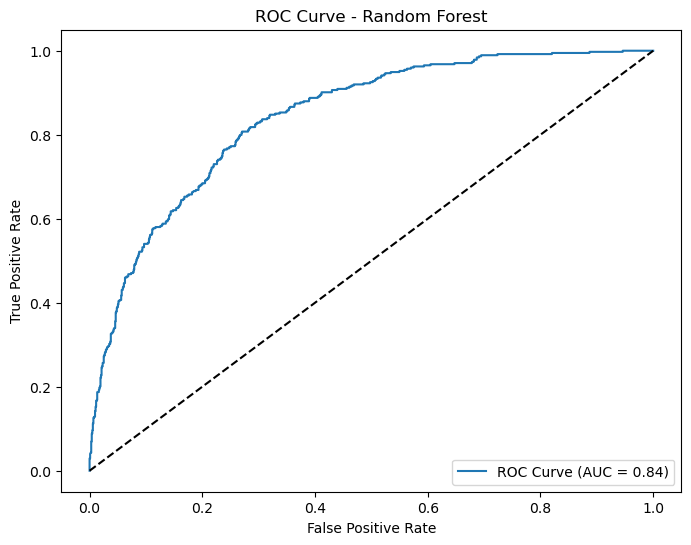

In [5]:
# Function to compute metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }
    print(f"{model_name} Metrics:", metrics)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.savefig(f"roc_curve_{model_name.lower().replace(' ', '_')}.png")
    plt.show()
    
    return metrics

# Evaluate both models
logreg_metrics = evaluate_model(best_logreg, X_test, y_test, "Logistic Regression")
rf_metrics = evaluate_model(best_rf, X_test, y_test, "Random Forest")

# Select best model (based on F1-score)
best_model = best_rf if rf_metrics["F1-Score"] > logreg_metrics["F1-Score"] else best_logreg
best_model_name = "Random Forest" if rf_metrics["F1-Score"] > logreg_metrics["F1-Score"] else "Logistic Regression"


# 5. Export Pipeline


In [6]:
# Export best model
joblib.dump(best_model, "churn_prediction_pipeline.joblib")
print(f"Exported {best_model_name} pipeline to churn_prediction_pipeline.joblib")

Exported Logistic Regression pipeline to churn_prediction_pipeline.joblib


# 6. Visualize Feature Importance (for Random Forest)

In [9]:
# If Random Forest is the best model, plot feature importance.

if best_model_name == "Random Forest":
    feature_names = numerical_cols + best_model.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out().tolist()
    importances = best_model.named_steps["classifier"].feature_importances_
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names)
    plt.title("Feature Importance - Random Forest")
    plt.xlabel("Importance")
    plt.savefig("feature_importance_rf.png")
    plt.show()